## Configuración inicial

A continuación se importan las librerías necesarias para el funcionamiento del notebook.

In [2]:
#plots and data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#metrics and transformations
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
#Model
from sklearn.ensemble import RandomForestRegressor



sns.set()

In [3]:
#function to measure the performance
def timeseries_evaluation_metrics_func(y_true, y_pred,flag):
    def mean_absolute_percentage_error(y_true, y_pred): 
        epsilon=0.1e-5
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    if flag : print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
    else:
        print('Evaluation metric results:')
        print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
        print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
        print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
        print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
        
    return {"MSE":metrics.mean_squared_error(y_true, y_pred),
           "MAE":metrics.mean_absolute_error(y_true, y_pred),
           "RMSE":np.sqrt(metrics.mean_squared_error(y_true, y_pred)),
           "MAPE":mean_absolute_percentage_error(y_true, y_pred)}

In [4]:
def plot_predict_test(df_test_y,testPredict,lag):
        ### Resultado predicción datos de entrenamiento
    fig, ax = plt.subplots(figsize=[15,8])
    sns.lineplot(df_test_y[lag:].flatten(),label="real")
    sns.lineplot(testPredict.flatten(),label="predicción")
    plt.title("Comparación valor real y predicción")
    plt.ylabel("value")

In [5]:
def createLagFeature(name_features,lag,df):
    for name_feature in name_features:
        for i in range(1,lag+1):
            df[name_feature+"lag"+str(i)]=df[name_feature].shift(i)
    return df

---

## Cargar y preparar los datos.

In [3]:
df = pd.read_csv("../../Datasets/Datos_durante_pandemia/data_durante_vol_ve_in_ic.csv")

df['Fecha'] = pd.to_datetime(df['Fecha'])
df = df.sort_values('Fecha', ascending=True)
df = df.rename(columns = {'Vol. Futuros': 'VolFuturos'})
df

Fecha  VolFuturos      TRM  Precio Interno        VIX  EMV-ID  \
0   2020-01-01    1.289946  3277.14        975000.0  12.548403    1.89   
1   2020-01-02    0.735046  3277.14        945000.0  12.470000    2.84   
2   2020-01-03    0.591834  3258.84        940000.0  14.020000    1.33   
3   2020-01-04    1.367154  3262.05        930000.0  14.646666    0.00   
4   2020-01-05    1.505321  3262.05        920000.0  14.311970    0.86   
..         ...         ...      ...             ...        ...     ...   
913 2022-07-02    0.778572  4198.77       2270000.0  25.922916   11.11   
914 2022-07-03    0.819483  4198.77       2270000.0  26.641413   23.06   
915 2022-07-04    0.843804  4198.77       2270000.0  27.530000   15.98   
916 2022-07-05    0.850985  4198.77       2280000.0  27.540000   18.90   
917 2022-07-06    0.840437  4259.86       2302000.0  26.730000    2.27   

        EPU    PI    MHI   FNI    SI  
0    186.06  0.00   0.00  0.00  0.00  
1    139.13  0.00   0.00  0.00  0.00  
2    108.10  0.00   0.00  0.00  0.00  
3    212.82  0.00   0.00  0.00  0.00  
4    173.76  0.00   0.00  0.00  0.00  
..      ...   ...    ...   ...   ...  
913  130.95  4.66  25.71  0.19 -3.56  
914  135.95  0.42   7.76  0.00 -3.67  
915  309.83  0.54  31.37  0.27 -5.85  
916  116.59  0.48  38.21  0.12 -4.97  
917   91.52  0.52  27.93  0.00 -7.87  

[918 rows x 11 columns]

---

## Desarrollo del modelo

In [7]:
#objects to scale the data 
sc=StandardScaler()
sc2=StandardScaler()

In [8]:
df_stats=df

In [9]:
#
len_data=df_stats.shape[0]

#get target
df_label=df_stats["VolFuturos"].values.reshape(len_data,1)
#get attributes
df_data=df_stats.drop(columns=["Fecha"])

#apply scale
#df_label=sc.fit_transform(df_label)
#df_data_normalize=sc2.fit_transform(df_data)


In [10]:
def Model(df_data,df_label,lag,estimators):
    
    df_data_lags=createLagFeature(df_data.columns,lag,df_data) if lag>0 else df_data
    df_data_lags.drop(columns="VolFuturos",inplace=True)
    df_data_lags=df_data_lags[lag:]
    #transform data
    df_data_lags=sc2.fit_transform(df_data_lags)
    
    #split data
    #last index of the train data
    seventy_percent=int(len_data*0.7)

    #split the data normalize
    
    df_train=df_data_lags[:seventy_percent]
    df_test=df_data_lags[seventy_percent:]

    #split labels
    df_label=df_label[lag:]
    df_train_y=df_label[:seventy_percent]
    df_test_y=df_label[seventy_percent:]
    #split labels normalize
    
    df_label_normalize=sc.fit_transform(df_label)
    df_train_y_normalize=df_label_normalize[:seventy_percent]
    df_test_y_normalize=df_label_normalize[seventy_percent:]
    print(df_test_y_normalize.shape)
    print(df_test.shape)


    #make model
    model=RandomForestRegressor(n_estimators=estimators)
    #fit the model with the train data
    history=model.fit(df_train,df_train_y_normalize)
   
    # make predictions
    trainPredict = model.predict(df_train)
    trainPredict = np.reshape(trainPredict,(len(trainPredict),1))
    # invert transformation
    trainPredict = sc.inverse_transform(trainPredict)
    trainY = df_train_y
    
    # make predictions
    testPredict = model.predict(df_test)
    # invert transformation
    testPredict = np.reshape(testPredict,(len(testPredict),1))
    testPredict = sc.inverse_transform(testPredict)
    testY = df_test_y
    print("len test: ",testY.shape)
    print("len PREDICT: ",testPredict.shape)
    
    plot_predict_test(df_train_y,trainPredict,lag)
    plot_predict_test(df_test_y,testPredict,lag)
    return [{"Fecha":df_stats.Fecha[lag:][:seventy_percent],"typeRandomForest":["train"]*len(trainPredict.flatten()),"RandomForest" :trainPredict.flatten()}
            ,{"Fecha":df_stats.Fecha[lag:][seventy_percent:],"typeRandomForest":["test"]*len(testPredict.flatten()),"RandomForest":testPredict.flatten()}]

    return {"train":timeseries_evaluation_metrics_func(trainY.flatten()+1, trainPredict.flatten()+1,False),
           "test":timeseries_evaluation_metrics_func(testY.flatten()+1, testPredict.flatten()+1,False)}

## Resultados

(273, 1)
(273, 39)


<ipython-input-21-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.24356143270165295
MAE is : 0.34387830301120387
RMSE is : 0.4935194349786571
MAPE is : 16.572658851750425
Evaluation metric results:
MSE is : 8.742384740750442
MAE is : 2.737486171858022
RMSE is : 2.9567523976062726
MAPE is : 160.07742473932643
(273, 1)
(273, 39)


<ipython-input-21-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.22702577493159226
MAE is : 0.3418228937405061
RMSE is : 0.47647221842578846
MAPE is : 16.667488908231377
Evaluation metric results:
MSE is : 12.83161306248543
MAE is : 3.3714981996369273
RMSE is : 3.5821240992580687
MAPE is : 193.23843334875028
(273, 1)
(273, 39)


<ipython-input-21-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.22104917073002064
MAE is : 0.3379622976877079
RMSE is : 0.47015866548434543
MAPE is : 16.58279213138103
Evaluation metric results:
MSE is : 13.032295091980608
MAE is : 3.393880404635245
RMSE is : 3.610027020948819
MAPE is : 194.2864059230972
(273, 1)
(273, 39)


<ipython-input-21-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.21617429972774727
MAE is : 0.33450424160090614
RMSE is : 0.4649454803821059
MAPE is : 16.475666766384045
Evaluation metric results:
MSE is : 12.352430611321617
MAE is : 3.3004039024713787
RMSE is : 3.5146024826887063
MAPE is : 189.55545941627142
(273, 1)
(273, 39)


<ipython-input-21-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.21850725038734603
MAE is : 0.33413125013002287
RMSE is : 0.4674475910595176
MAPE is : 16.314954982432837
Evaluation metric results:
MSE is : 11.850560667580835
MAE is : 3.2297266743574777
RMSE is : 3.442464330618523
MAPE is : 185.87232546196452
(271, 1)
(271, 59)


<ipython-input-21-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.2242914781086741
MAE is : 0.3443863368053295
RMSE is : 0.4735942124949101
MAPE is : 16.98038841682219
Evaluation metric results:
MSE is : 16.576760219563216
MAE is : 3.8282699039111465
RMSE is : 4.071456768720898
MAPE is : 218.0415846769784
(271, 1)
(271, 59)


<ipython-input-21-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.2237042597810236
MAE is : 0.3391333674587701
RMSE is : 0.47297384682561844
MAPE is : 16.627191372293478
Evaluation metric results:
MSE is : 13.37484452895952
MAE is : 3.4320481079084715
RMSE is : 3.657163453957113
MAPE is : 197.35447769603516
(271, 1)
(271, 59)


<ipython-input-21-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.21151706271757167
MAE is : 0.33300107284458197
RMSE is : 0.4599098419446704
MAPE is : 16.387123586242822
Evaluation metric results:
MSE is : 16.10362630121311
MAE is : 3.7856432613083415
RMSE is : 4.012932381839135
MAPE is : 215.5074786942685
(271, 1)
(271, 59)


<ipython-input-21-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.2168597828010786
MAE is : 0.3348779543277149
RMSE is : 0.4656820619275329
MAPE is : 16.438433193871173
Evaluation metric results:
MSE is : 16.861099227401915
MAE is : 3.8726171429332688
RMSE is : 4.106226884550087
MAPE is : 219.95603552247672
(271, 1)
(271, 59)


<ipython-input-21-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.2138961745594733
MAE is : 0.3351153791044629
RMSE is : 0.46248910750359656
MAPE is : 16.434916312671763
Evaluation metric results:
MSE is : 17.011102436716502
MAE is : 3.891739593142004
RMSE is : 4.124451774080587
MAPE is : 221.06306210734772
(269, 1)
(269, 79)


<ipython-input-21-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.24496190759540365
MAE is : 0.35146966224987486
RMSE is : 0.4949362661953594
MAPE is : 16.927902664515955
Evaluation metric results:
MSE is : 15.534646534935574
MAE is : 3.7089344545758514
RMSE is : 3.9414015952368486
MAPE is : 211.65950668671064


<ipython-input-15-f7487097fa4e>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=[15,8])


(269, 1)
(269, 79)


<ipython-input-21-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.23533871876428133
MAE is : 0.34161703369756685
RMSE is : 0.48511722167356763
MAPE is : 16.483297080100552
Evaluation metric results:
MSE is : 13.37834443679668
MAE is : 3.424593420142763
RMSE is : 3.6576419229876347
MAPE is : 196.9181786292447
(269, 1)
(269, 79)


<ipython-input-21-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.22320698703292752
MAE is : 0.34292276795351084
RMSE is : 0.47244786700008234
MAPE is : 16.786886875537103
Evaluation metric results:
MSE is : 15.64855318867904
MAE is : 3.732374959059395
RMSE is : 3.9558252222107892
MAPE is : 212.82065862651208
(269, 1)
(269, 79)


<ipython-input-21-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.21413568962405827
MAE is : 0.3343487617518787
RMSE is : 0.4627479763586852
MAPE is : 16.36058600501535
Evaluation metric results:
MSE is : 13.409076320286344
MAE is : 3.4339150764411364
RMSE is : 3.661840564563993
MAPE is : 197.16451997042873
(269, 1)
(269, 79)


<ipython-input-21-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.21587960758558827
MAE is : 0.33944812436488286
RMSE is : 0.46462846187635587
MAPE is : 16.626272913396566
Evaluation metric results:
MSE is : 14.419037346967533
MAE is : 3.568937620039584
RMSE is : 3.7972407544120155
MAPE is : 204.19032074410998
(268, 1)
(268, 89)


<ipython-input-21-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.2466208638580434
MAE is : 0.35094712533571637
RMSE is : 0.4966093674690837
MAPE is : 16.932223217819587
Evaluation metric results:
MSE is : 9.253239430052957
MAE is : 2.8193022797619656
RMSE is : 3.041913777550731
MAPE is : 164.32221794265766
(268, 1)
(268, 89)


<ipython-input-21-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.21380871237623922
MAE is : 0.33826408153889714
RMSE is : 0.4623945418971111
MAPE is : 16.66711102512573
Evaluation metric results:
MSE is : 8.64959841897938
MAE is : 2.7278720943270205
RMSE is : 2.9410199623564917
MAPE is : 159.7082657691017
(268, 1)
(268, 89)


<ipython-input-21-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.2166924741828313
MAE is : 0.33795793670451224
RMSE is : 0.4655023890194671
MAPE is : 16.60918036769649
Evaluation metric results:
MSE is : 9.313513429389637
MAE is : 2.8338616471566596
RMSE is : 3.051804946157214
MAPE is : 165.62806277988375
(268, 1)
(268, 89)


<ipython-input-21-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.21759359297037445
MAE is : 0.3380867744493962
RMSE is : 0.46646928405884824
MAPE is : 16.509274553709673
Evaluation metric results:
MSE is : 10.003892242060207
MAE is : 2.942614075751893
RMSE is : 3.162893017801931
MAPE is : 171.3452835871624
(268, 1)
(268, 89)


<ipython-input-21-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.21652884670440412
MAE is : 0.3364996261101697
RMSE is : 0.46532660218861777
MAPE is : 16.507463017551025
Evaluation metric results:
MSE is : 7.9542418327393545
MAE is : 2.610364543488176
RMSE is : 2.820326547181967
MAPE is : 153.52396700554013
(266, 1)
(266, 109)


<ipython-input-21-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.2208646794369064
MAE is : 0.342819917040129
RMSE is : 0.469962423430753
MAPE is : 16.995298885401613
Evaluation metric results:
MSE is : 7.387764591757144
MAE is : 2.516400819715483
RMSE is : 2.7180442586089626
MAPE is : 148.64239787733248
(266, 1)
(266, 109)


<ipython-input-21-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.2274859648161534
MAE is : 0.33750328907639954
RMSE is : 0.47695488761113813
MAPE is : 16.34768653311978
Evaluation metric results:
MSE is : 8.642011354170243
MAE is : 2.7340227386799123
RMSE is : 2.9397298097223565
MAPE is : 160.6048521395776
(266, 1)
(266, 109)


<ipython-input-21-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.2118054180159061
MAE is : 0.33349528024273395
RMSE is : 0.4602232262890543
MAPE is : 16.232975556176708
Evaluation metric results:
MSE is : 8.549527670971687
MAE is : 2.7270391483120044
RMSE is : 2.9239575357675234
MAPE is : 160.22273786633602
(266, 1)
(266, 109)


<ipython-input-21-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.2131988127731948
MAE is : 0.3327079625241618
RMSE is : 0.46173456961028464
MAPE is : 16.169258242970418
Evaluation metric results:
MSE is : 8.324800154319092
MAE is : 2.683595161520765
RMSE is : 2.885272977435427
MAPE is : 157.8084158602639
(266, 1)
(266, 109)


<ipython-input-21-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.21738995080511814
MAE is : 0.335434302909603
RMSE is : 0.46625095260505167
MAPE is : 16.497252518458897
Evaluation metric results:
MSE is : 7.795371845522048
MAE is : 2.587333728836741
RMSE is : 2.792019313243024
MAPE is : 152.7262379389262
(261, 1)
(261, 159)


<ipython-input-21-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.22261455144274728
MAE is : 0.3392225532049181
RMSE is : 0.4718204652648582
MAPE is : 16.666247487002174
Evaluation metric results:
MSE is : 7.286298404585012
MAE is : 2.4825992765165013
RMSE is : 2.6993144323299965
MAPE is : 146.24759299080833
(261, 1)
(261, 159)


<ipython-input-21-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.212935002151129
MAE is : 0.33364168478355594
RMSE is : 0.4614488077253305
MAPE is : 16.388851441923393
Evaluation metric results:
MSE is : 9.588143088448602
MAE is : 2.8742637603954826
RMSE is : 3.096472684918858
MAPE is : 167.27400007798397
(261, 1)
(261, 159)


<ipython-input-21-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.21266528516144848
MAE is : 0.3357671906910076
RMSE is : 0.4611564649459535
MAPE is : 16.43817996099934
Evaluation metric results:
MSE is : 7.269257815207169
MAE is : 2.4791910602160376
RMSE is : 2.696156118478151
MAPE is : 145.9313359316625
(261, 1)
(261, 159)


<ipython-input-21-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.2094061129901529
MAE is : 0.33119218923103816
RMSE is : 0.4576091268650057
MAPE is : 16.207277792264545
Evaluation metric results:
MSE is : 7.099546778558161
MAE is : 2.449665476102586
RMSE is : 2.664497472049497
MAPE is : 144.32865721699082
(261, 1)
(261, 159)


<ipython-input-21-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.21184976759412252
MAE is : 0.3342911064621404
RMSE is : 0.46027140644854586
MAPE is : 16.352295471892596
Evaluation metric results:
MSE is : 7.635815970468922
MAE is : 2.5448649343551155
RMSE is : 2.7632980241857594
MAPE is : 149.56715894641036


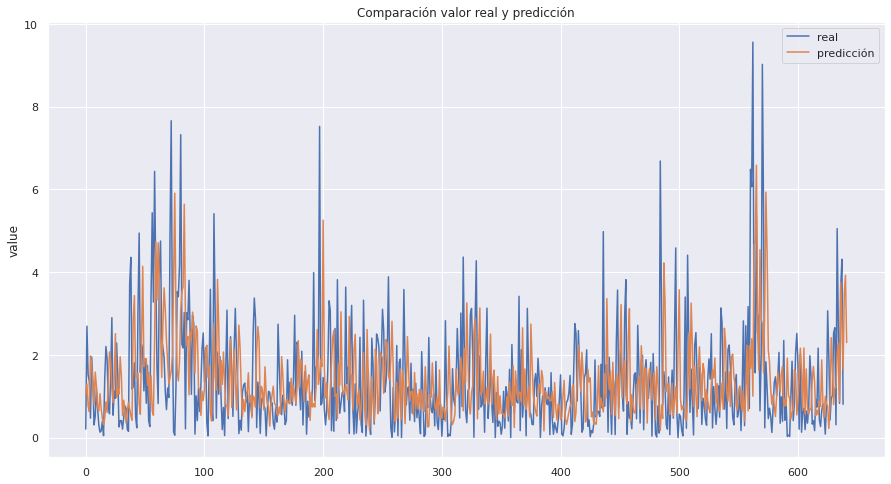

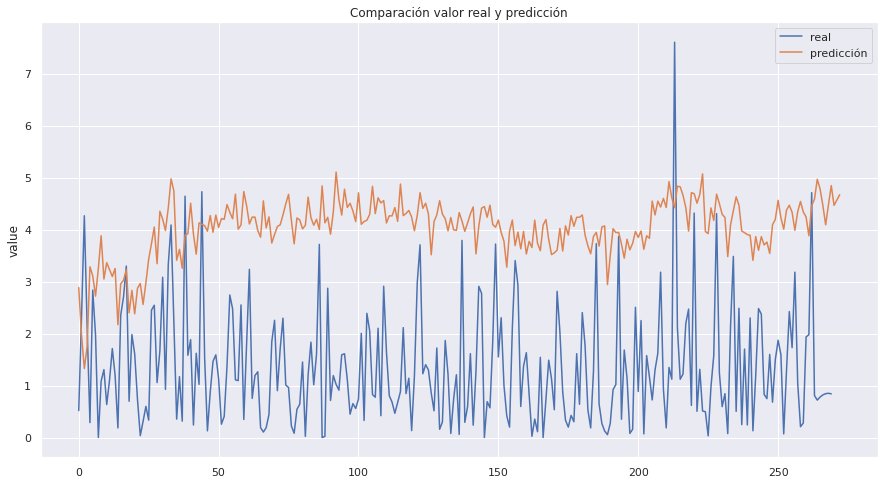

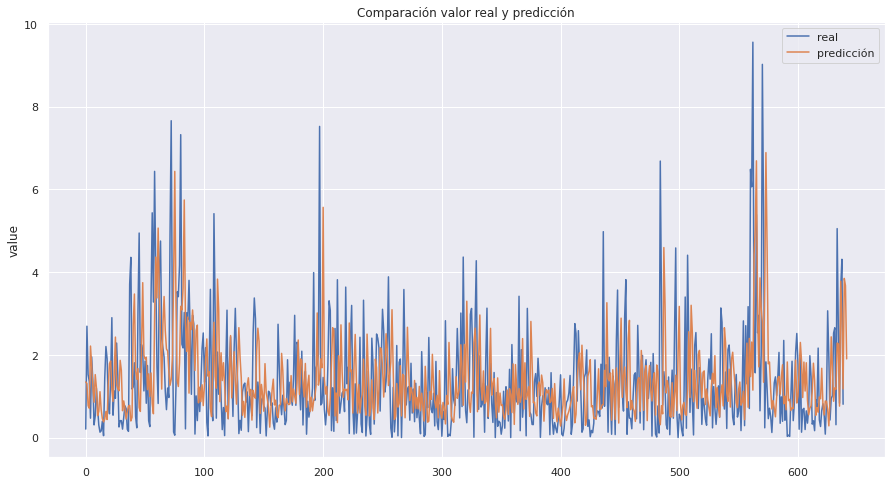

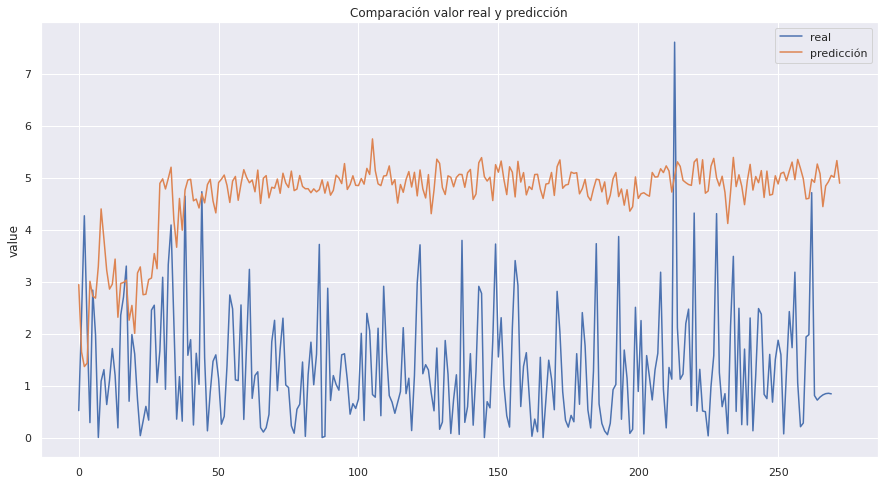

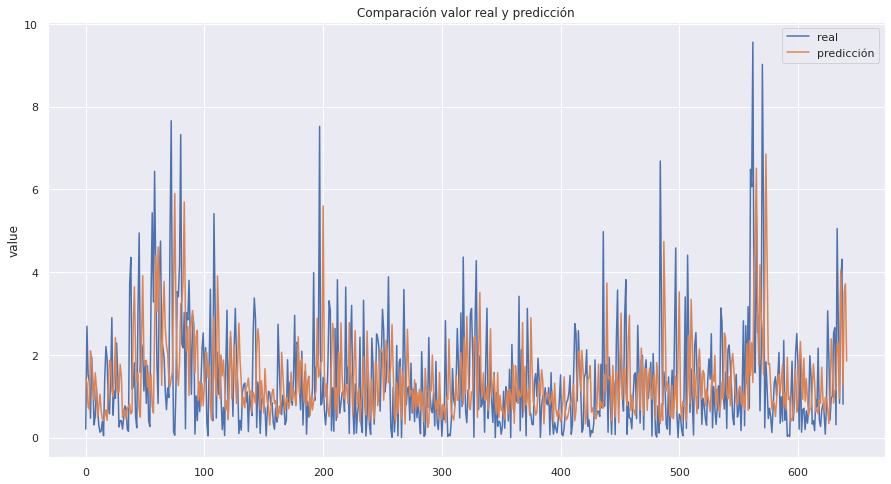

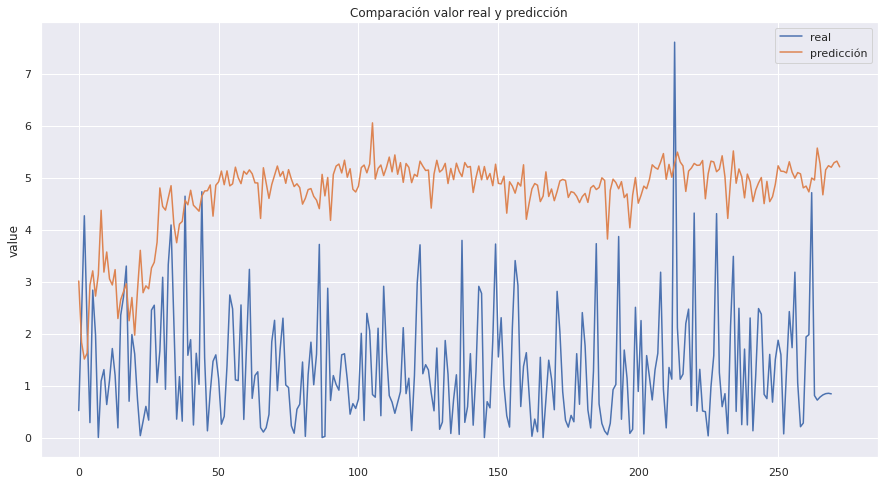

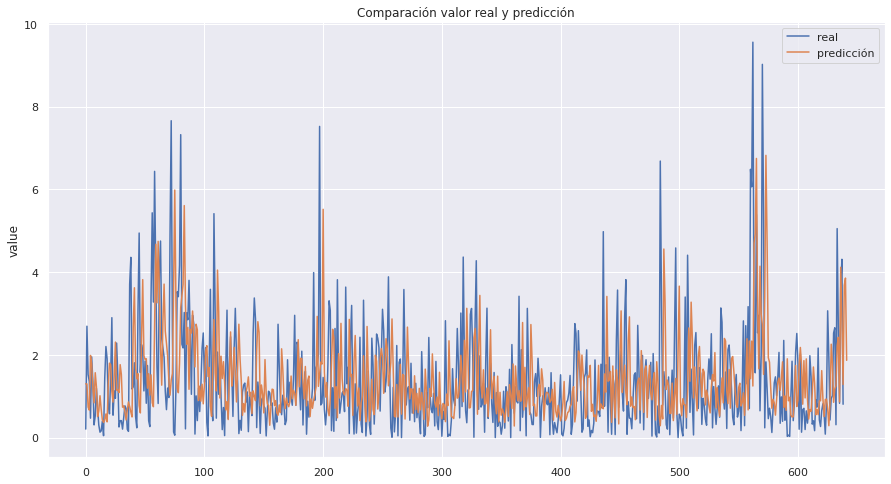

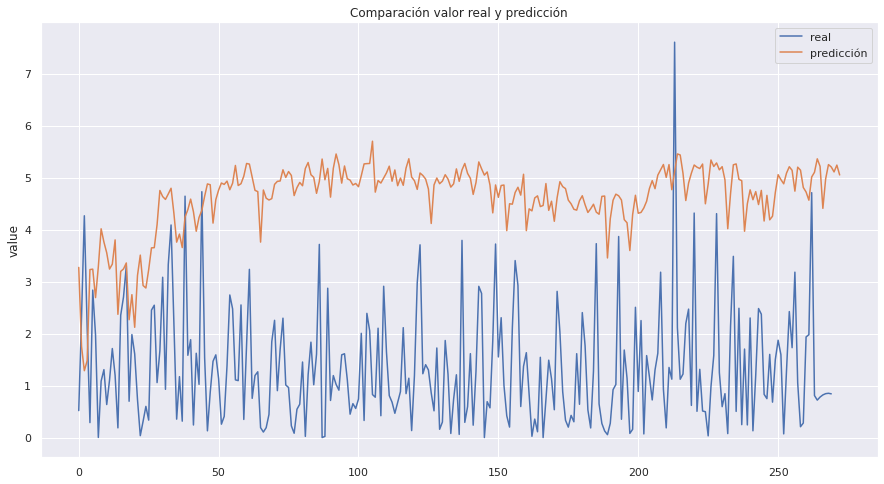

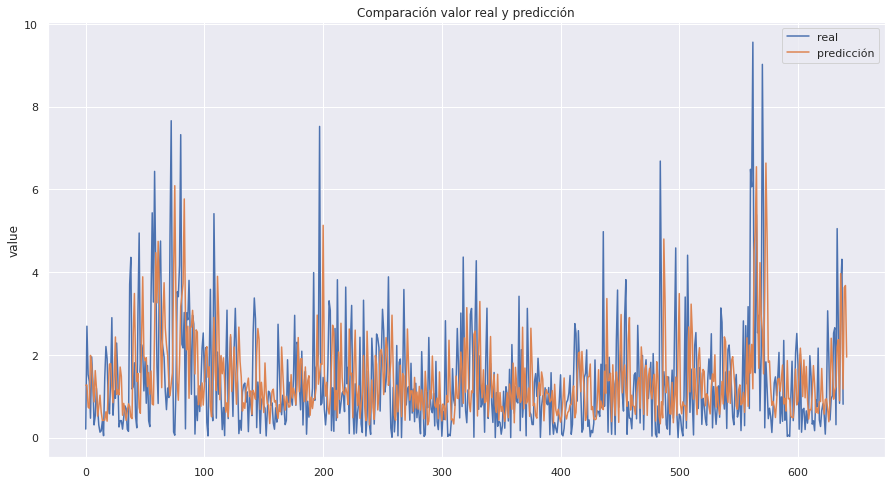

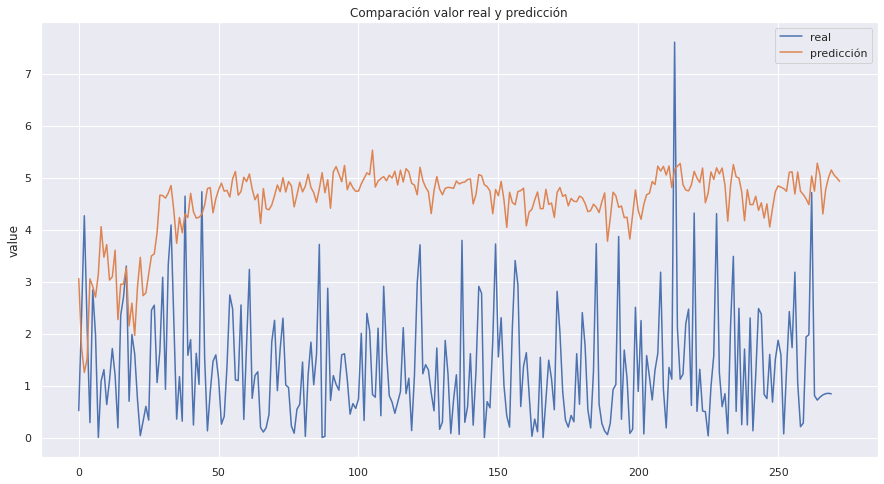

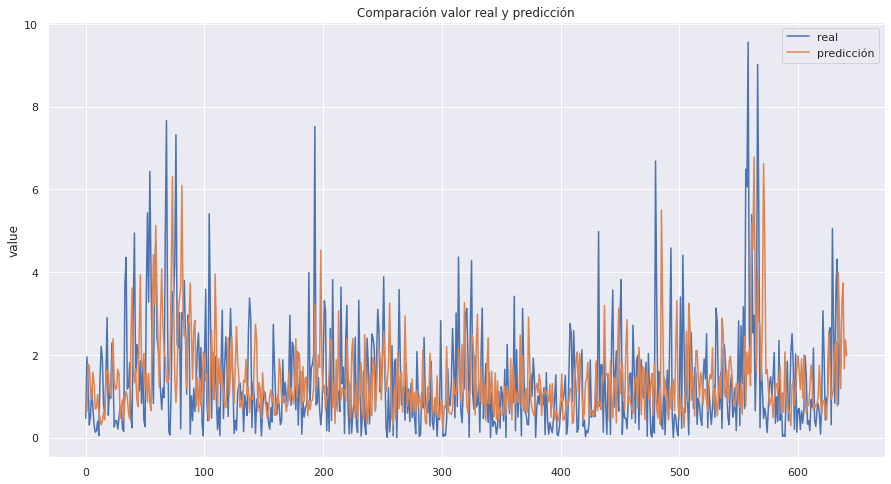

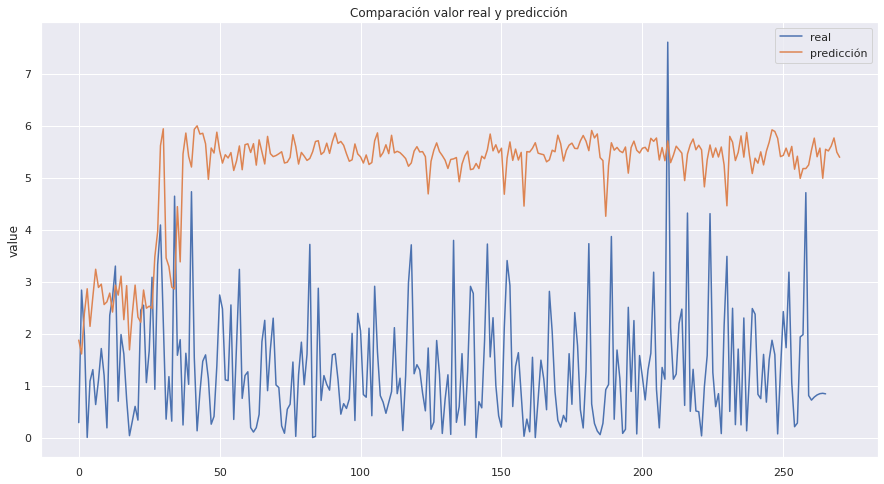

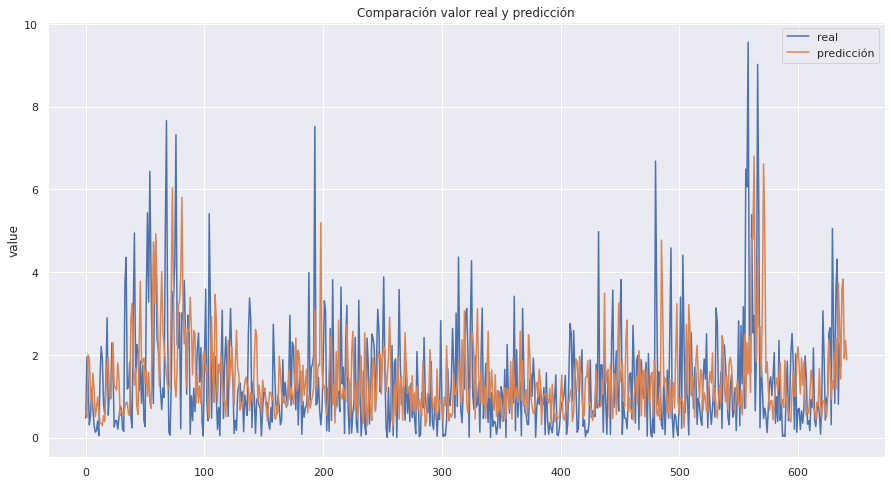

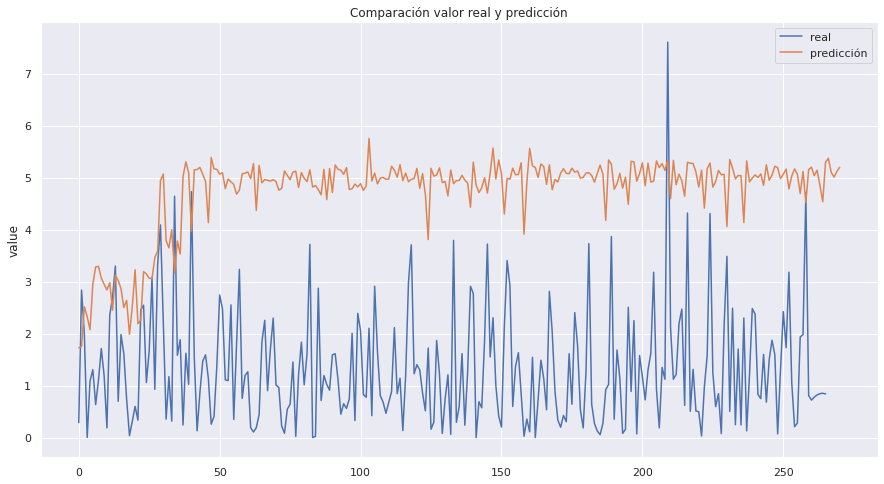

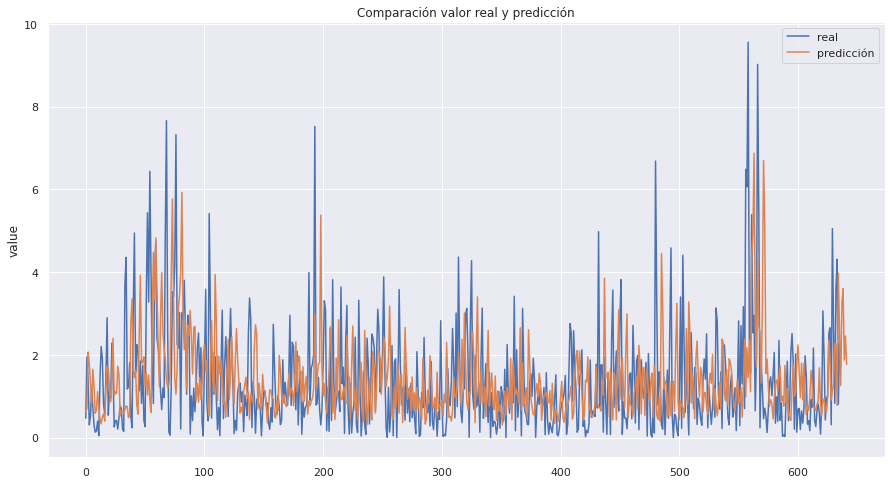

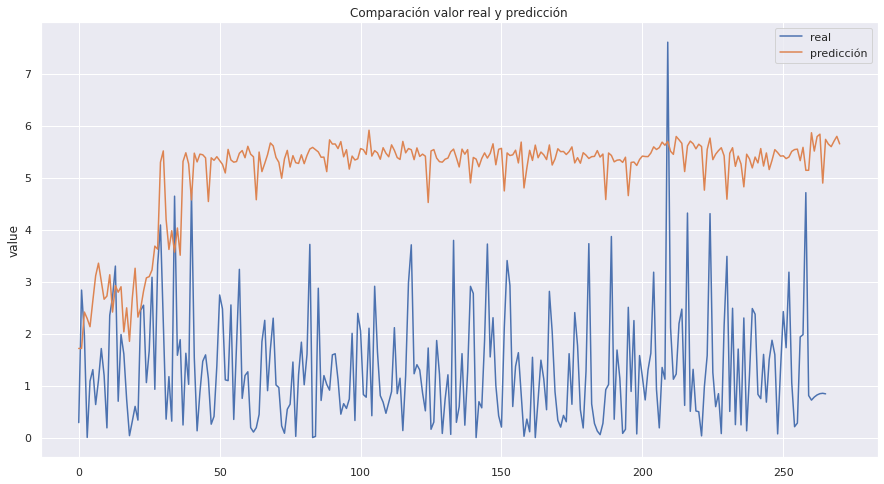

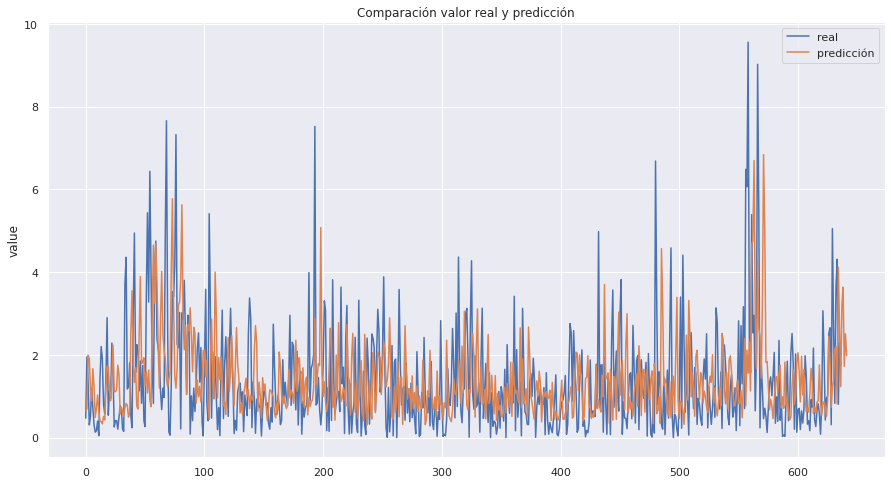

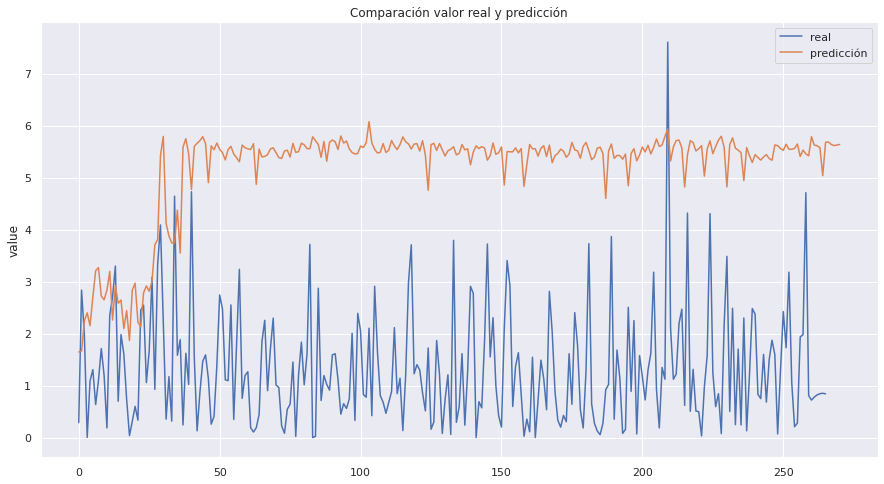

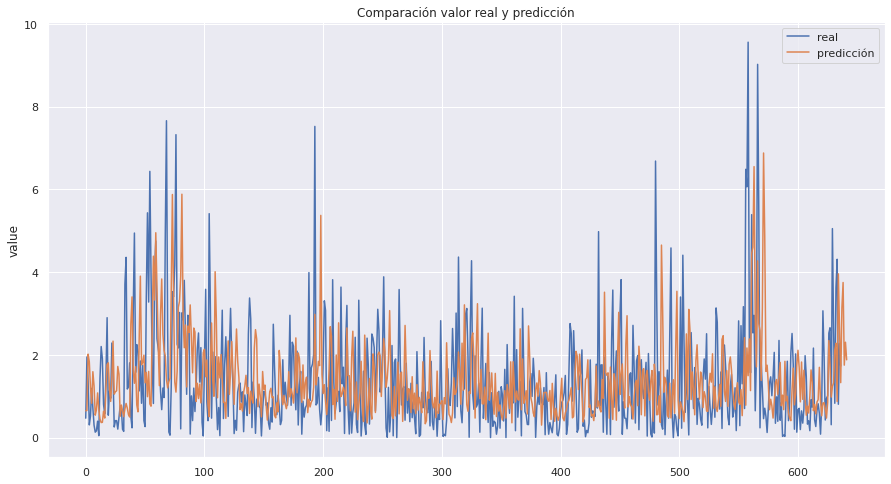

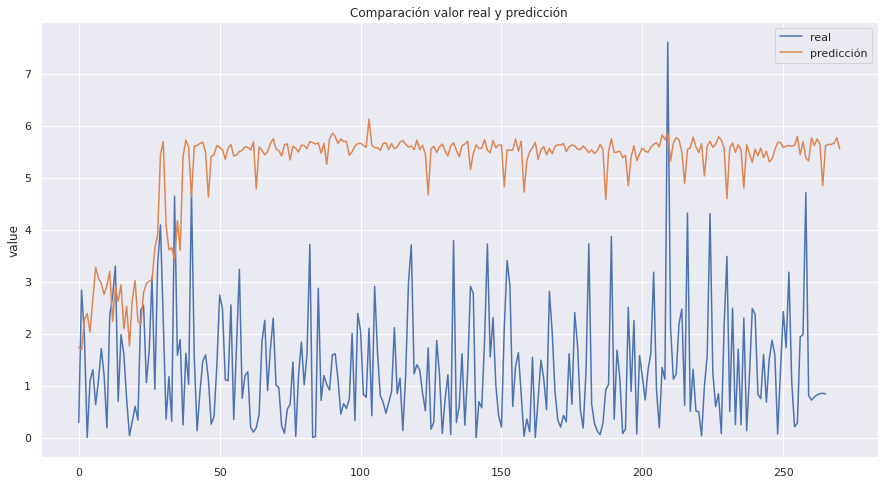

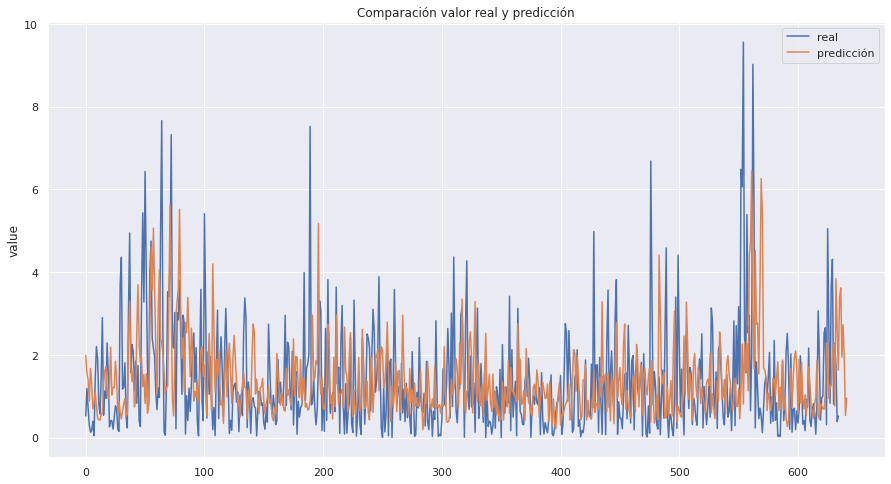

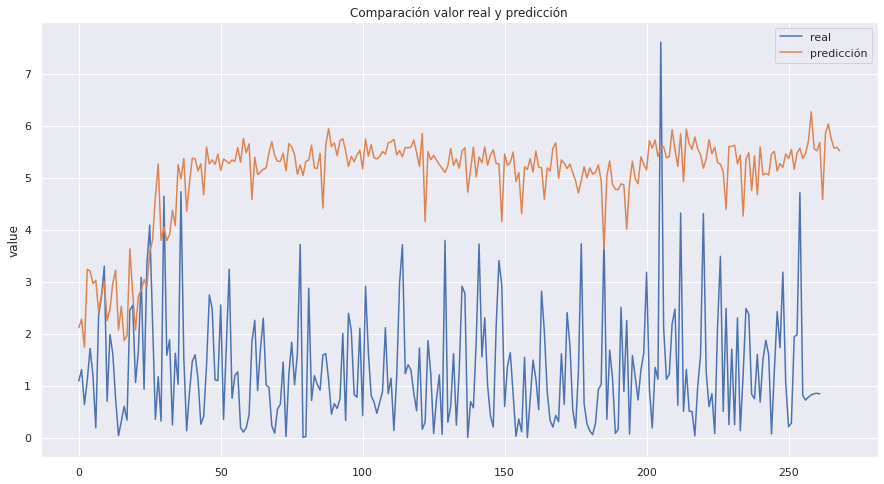

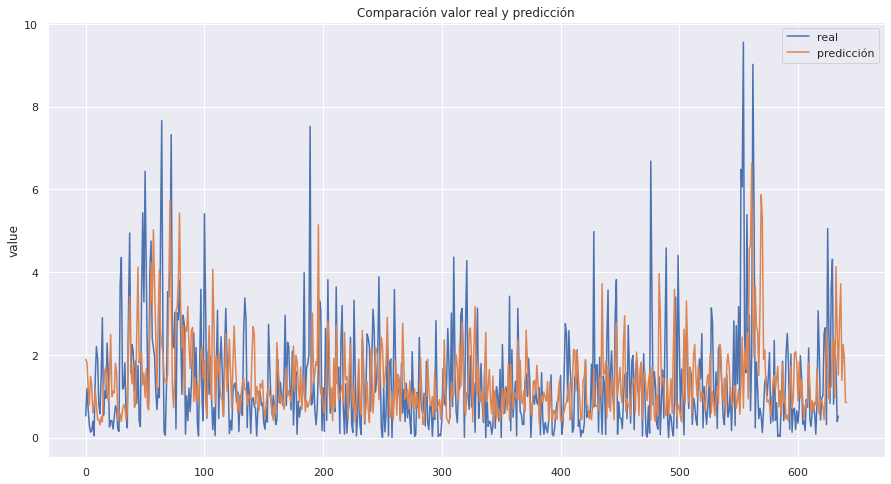

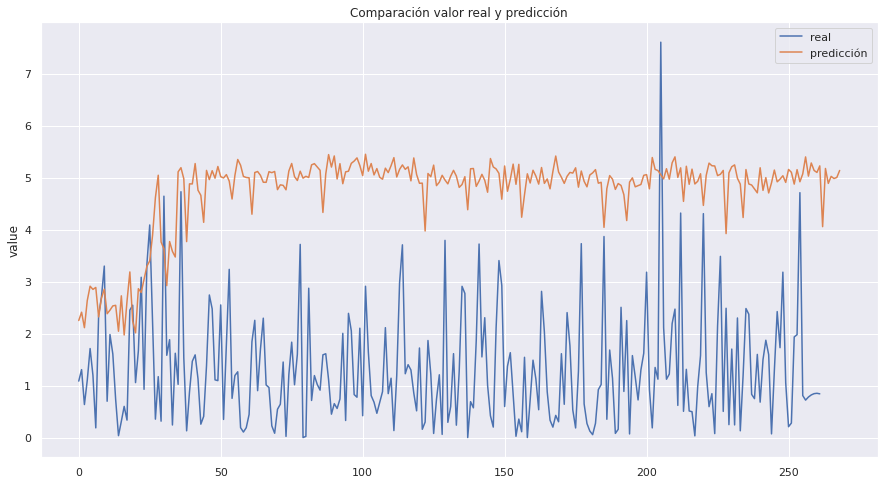

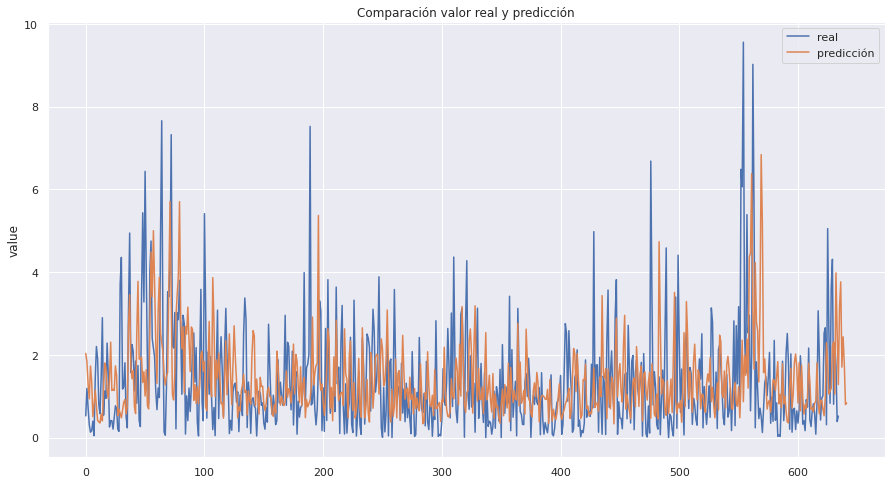

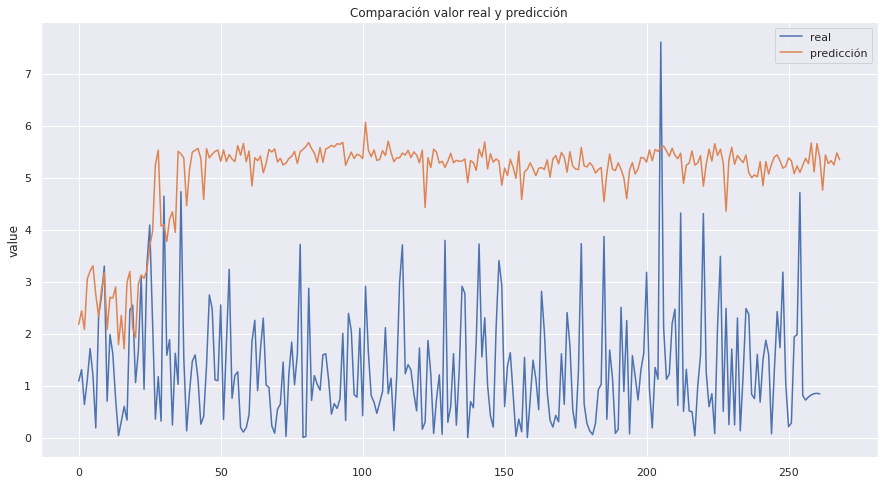

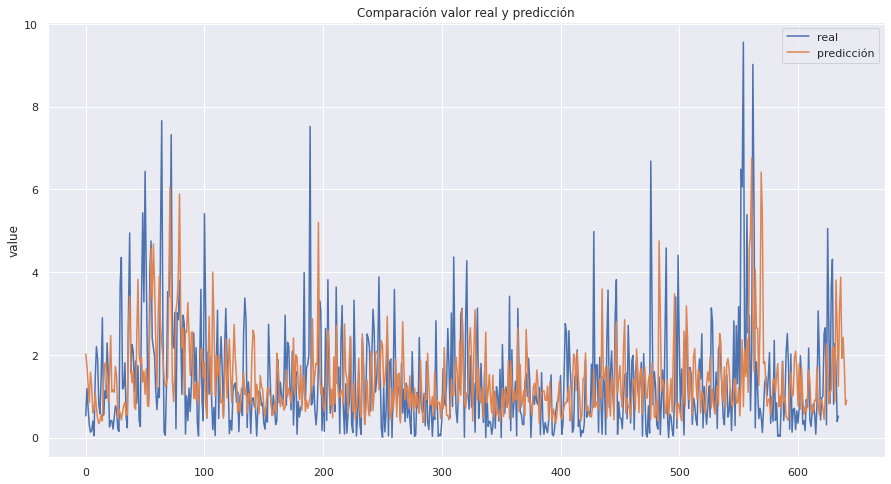

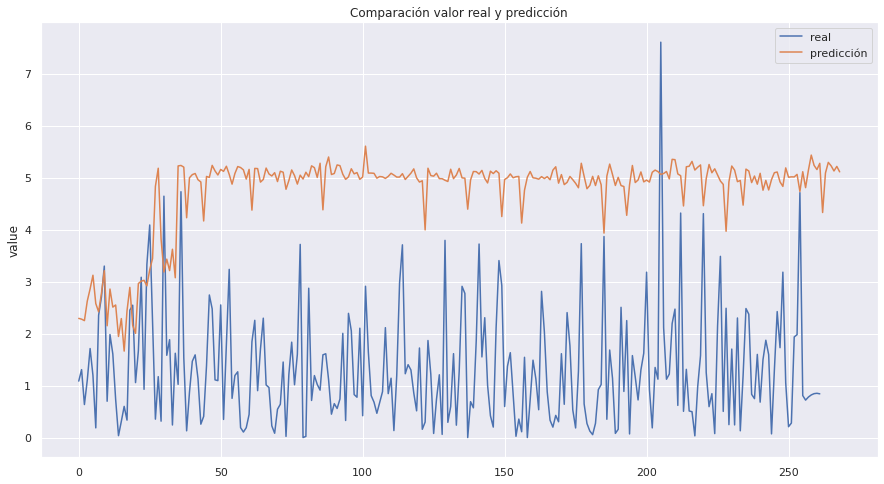

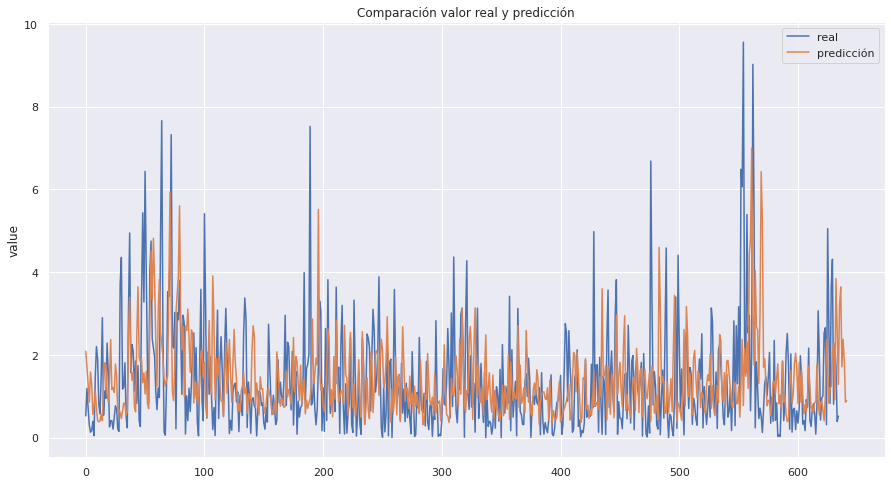

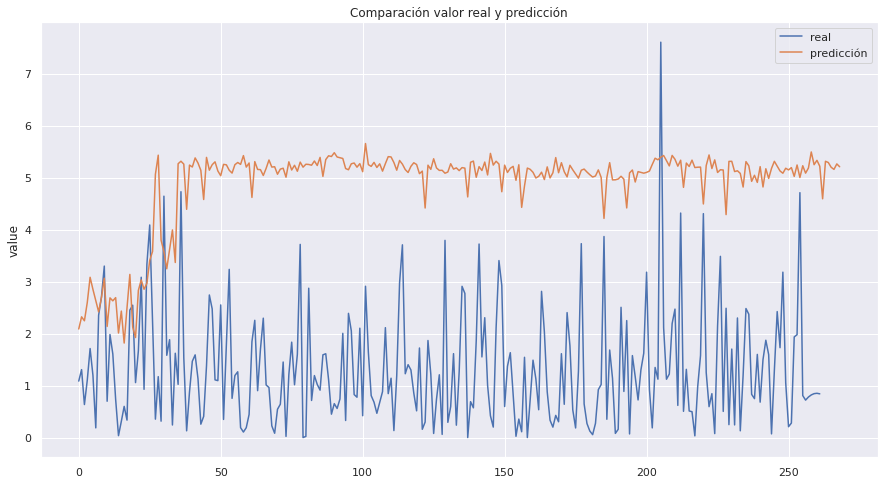

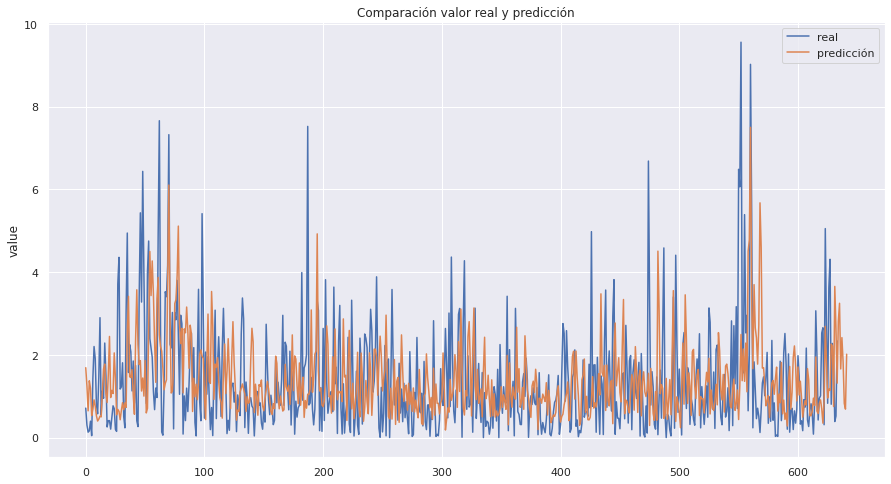

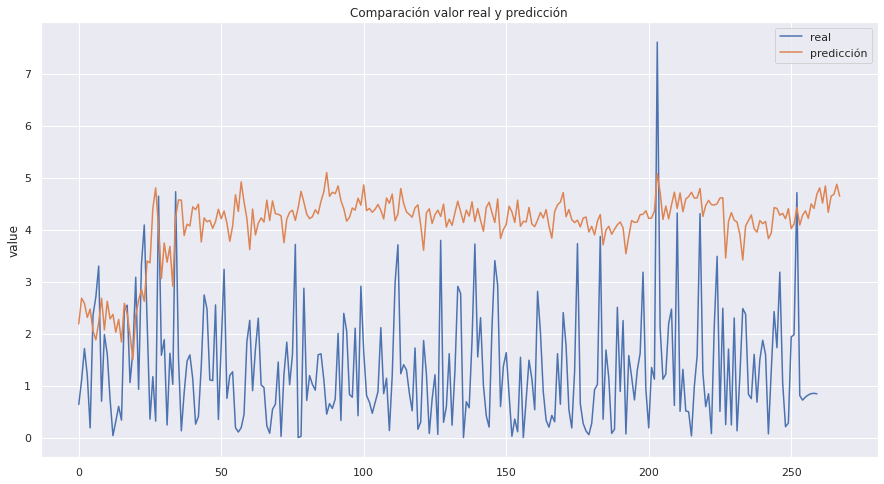

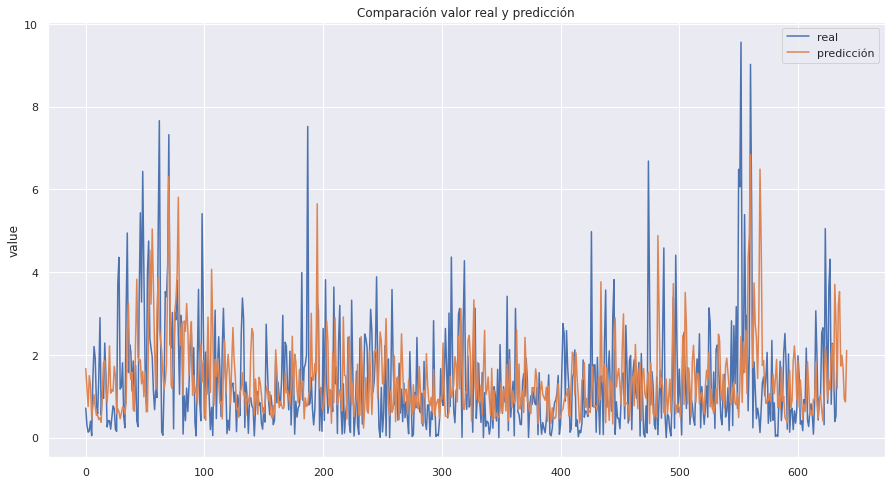

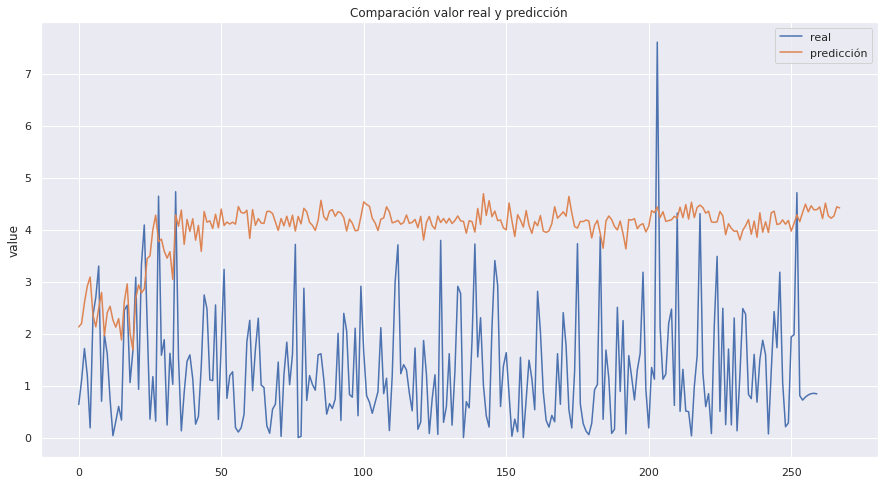

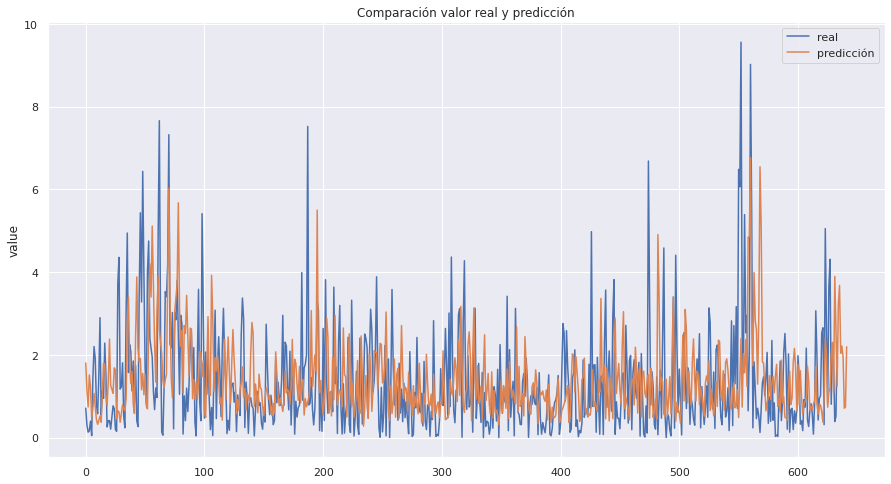

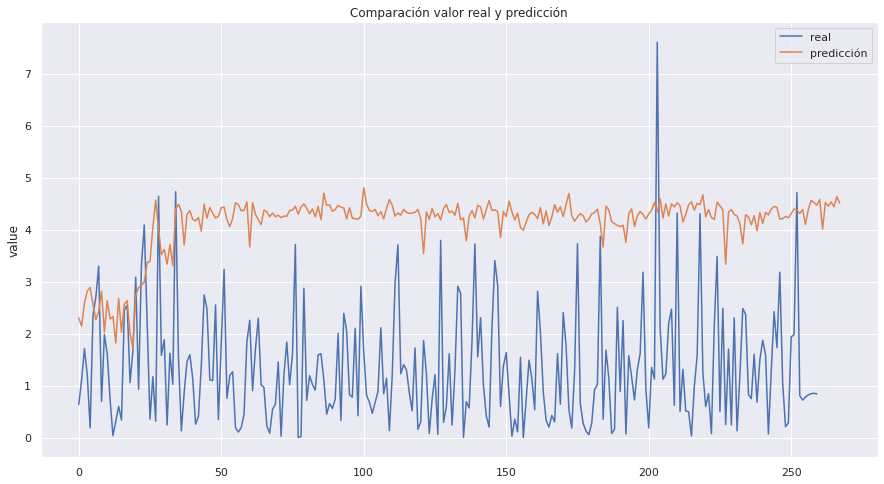

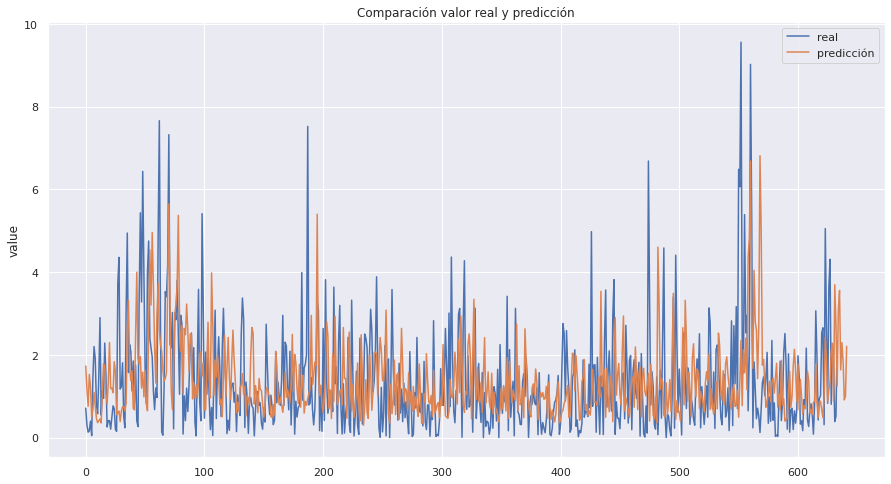

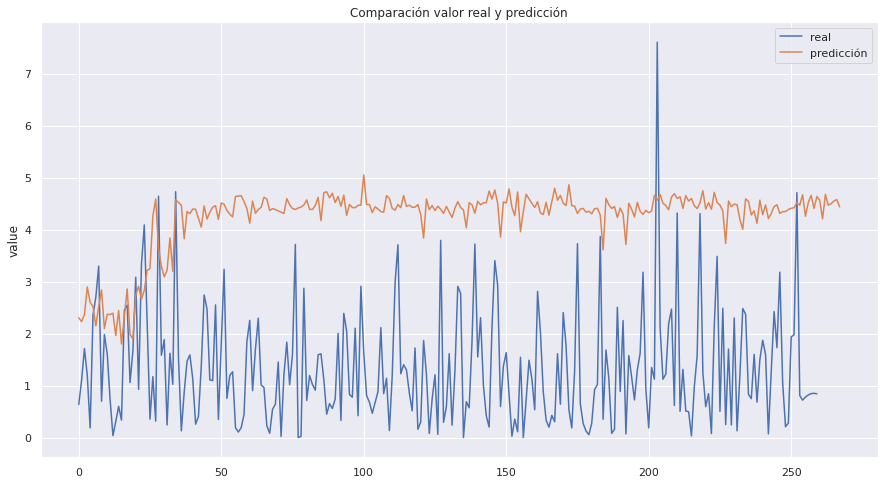

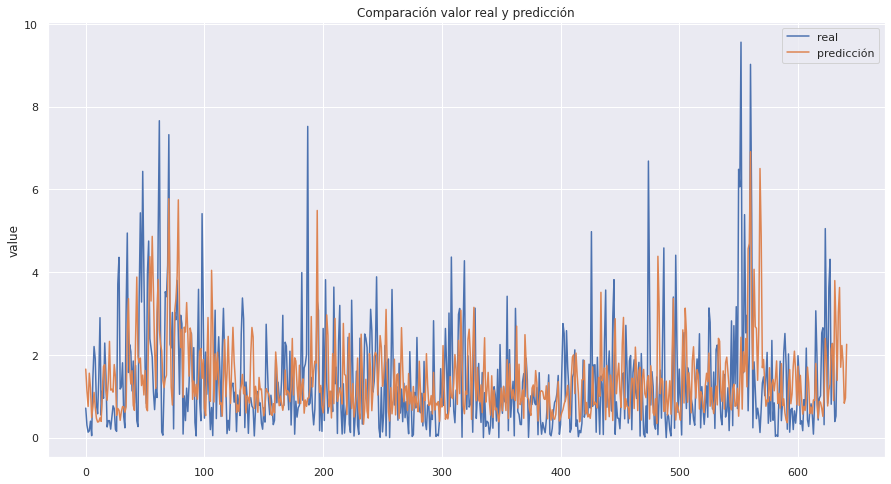

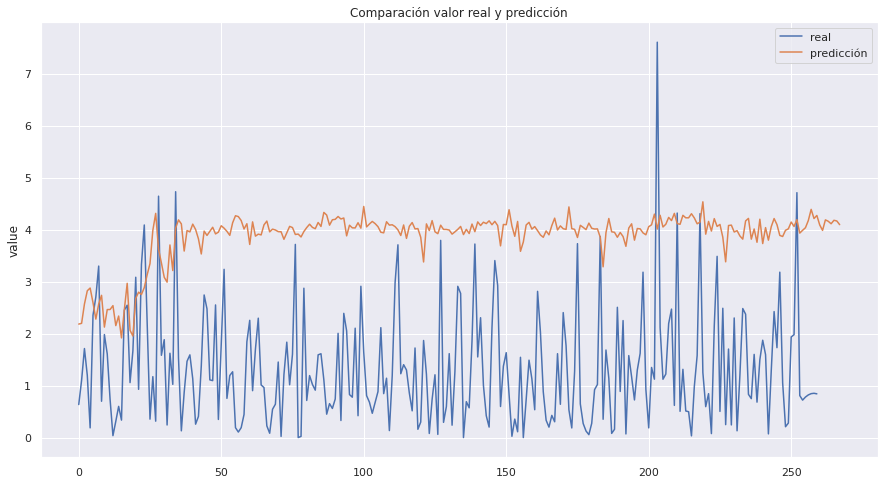

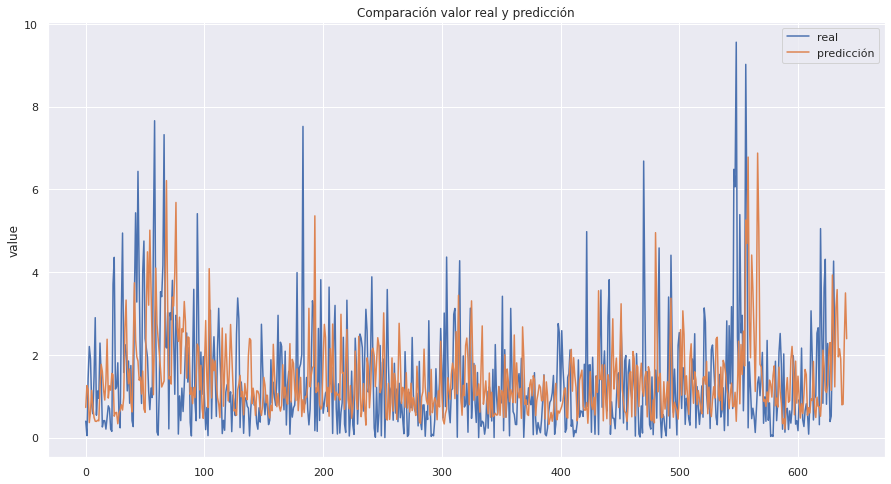

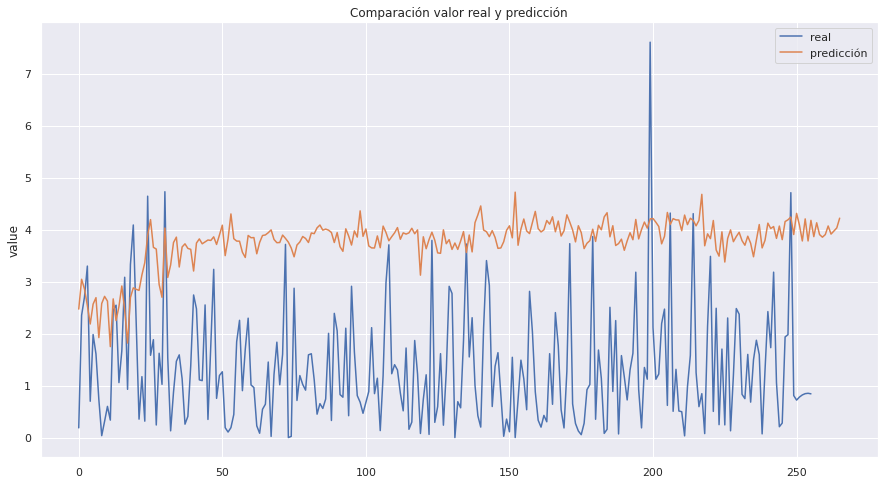

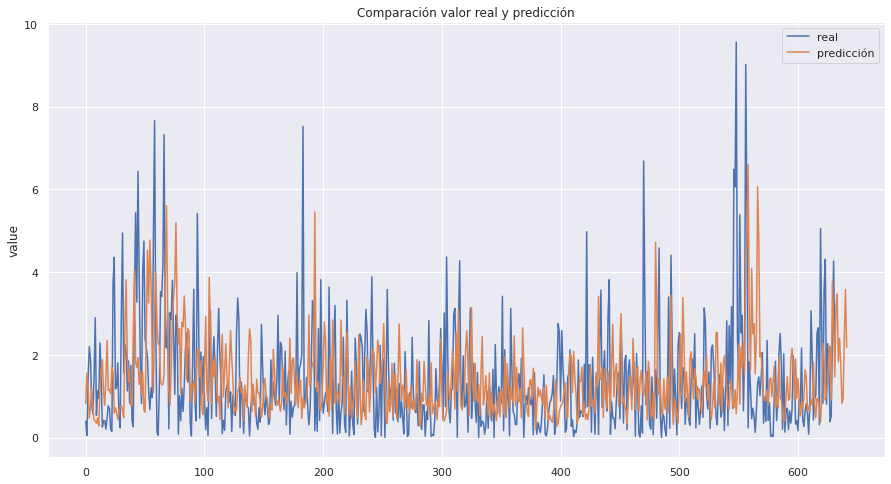

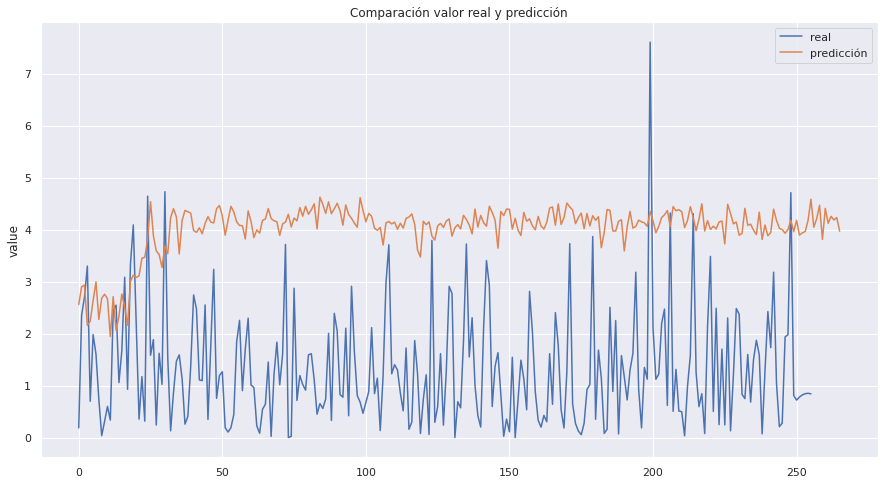

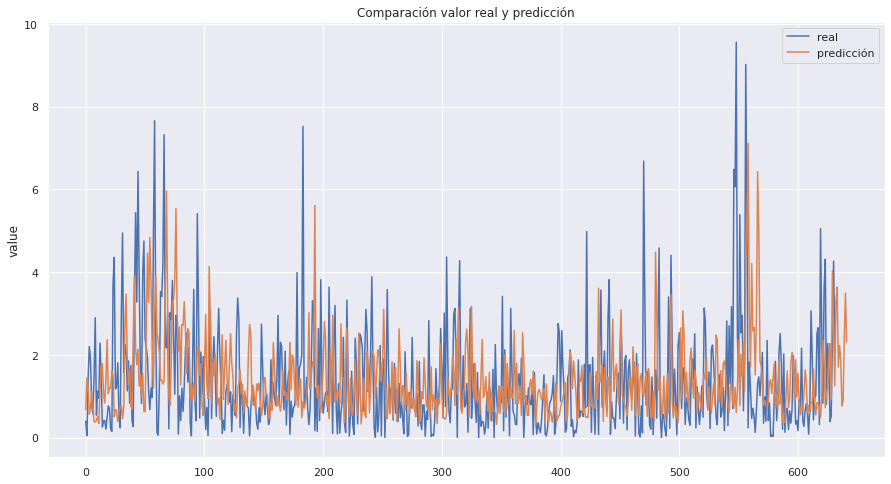

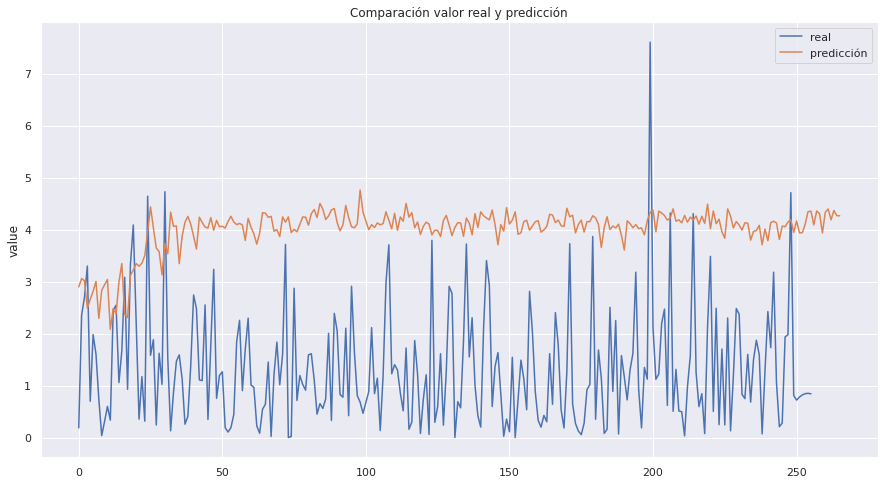

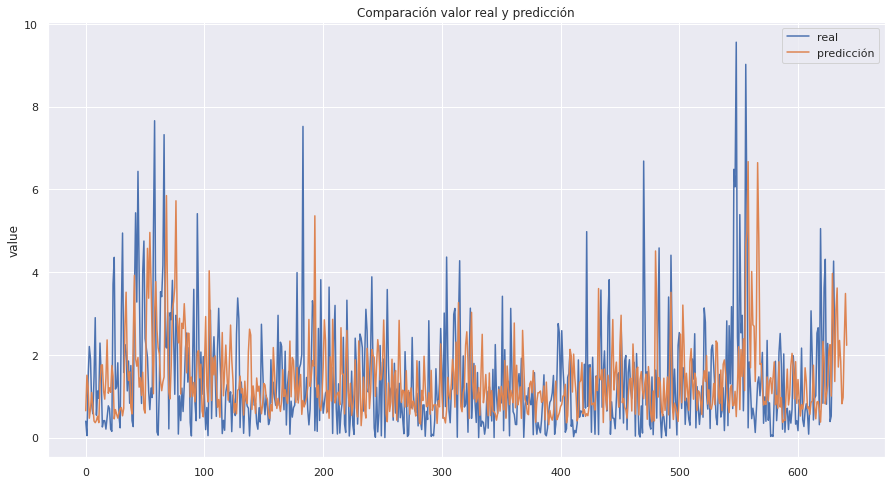

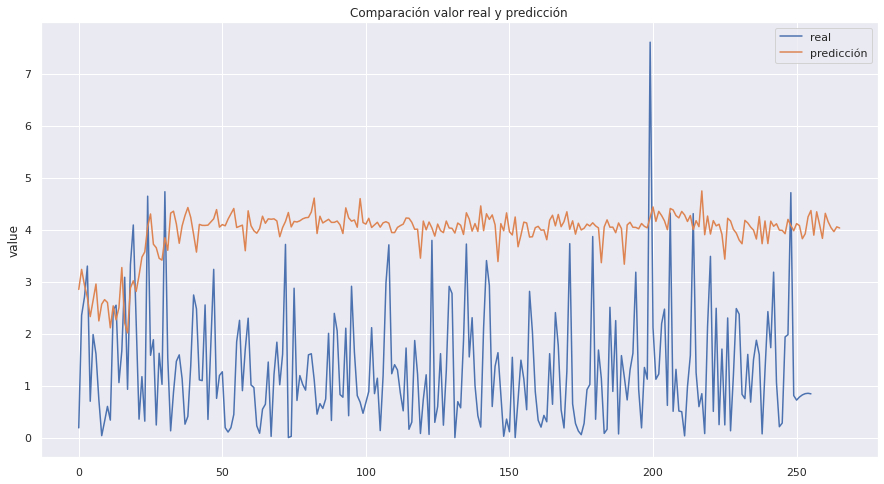

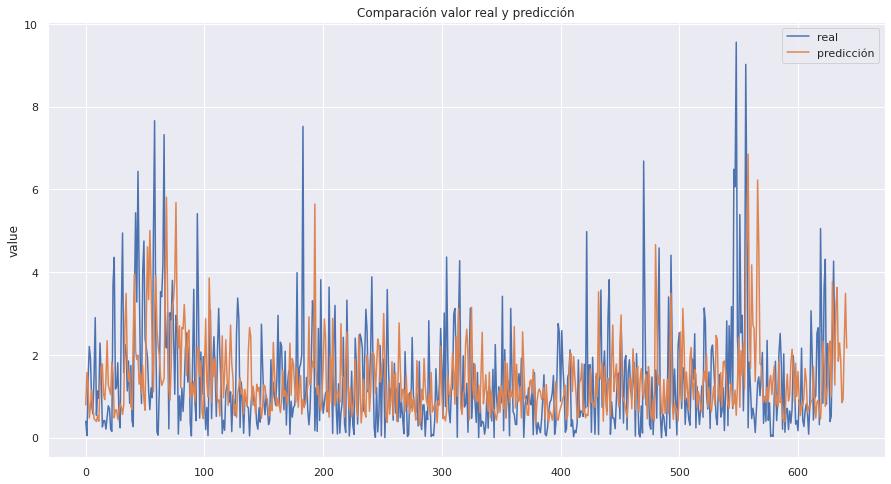

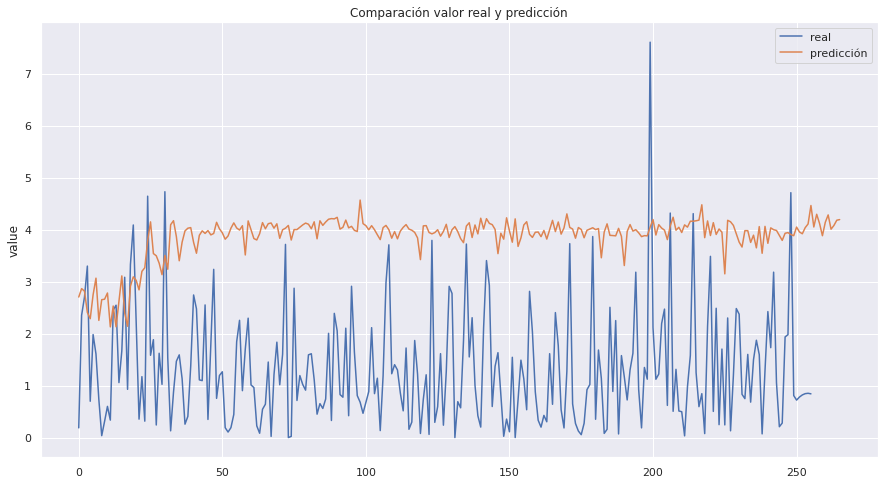

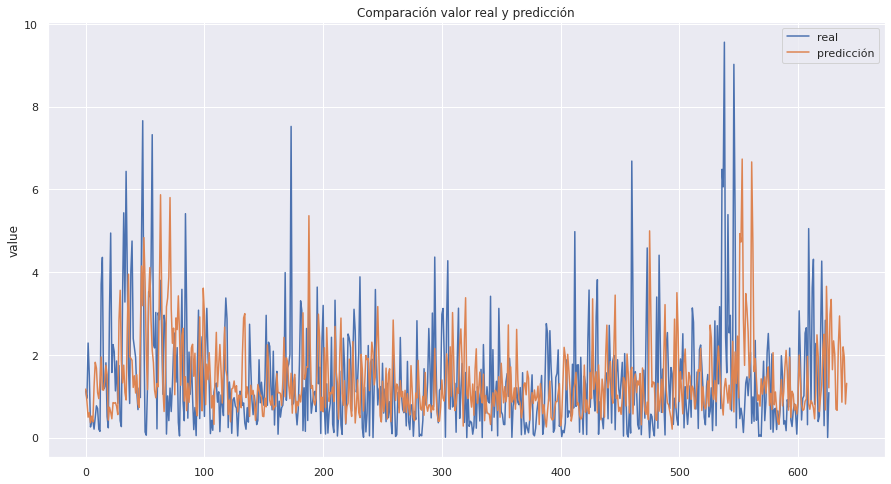

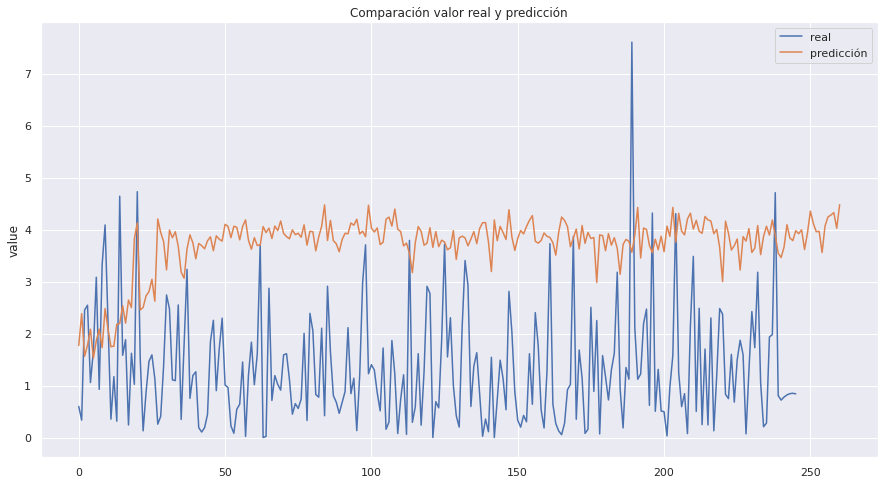

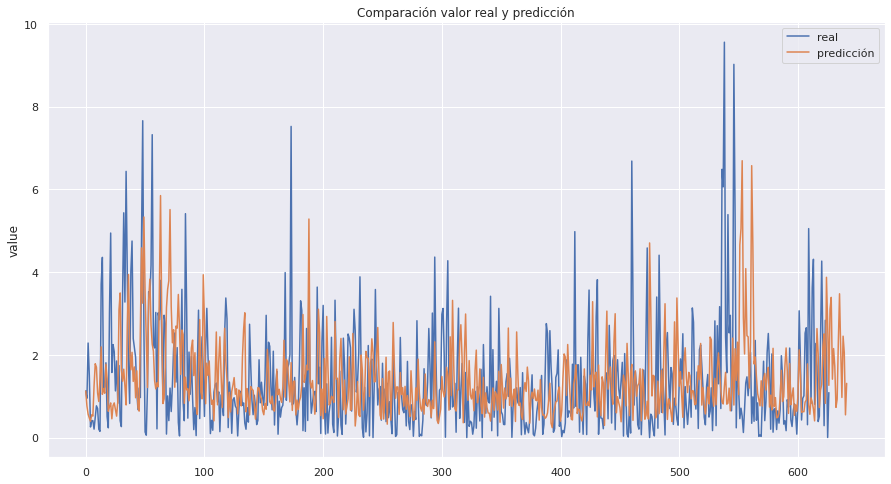

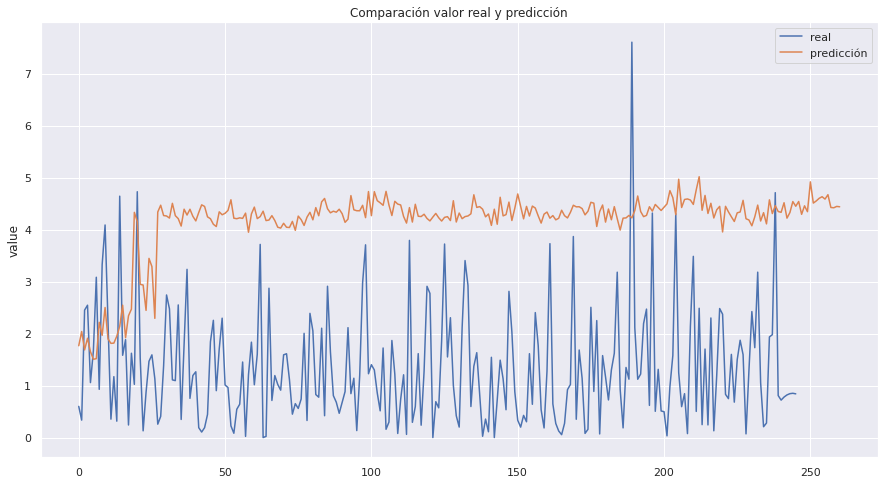

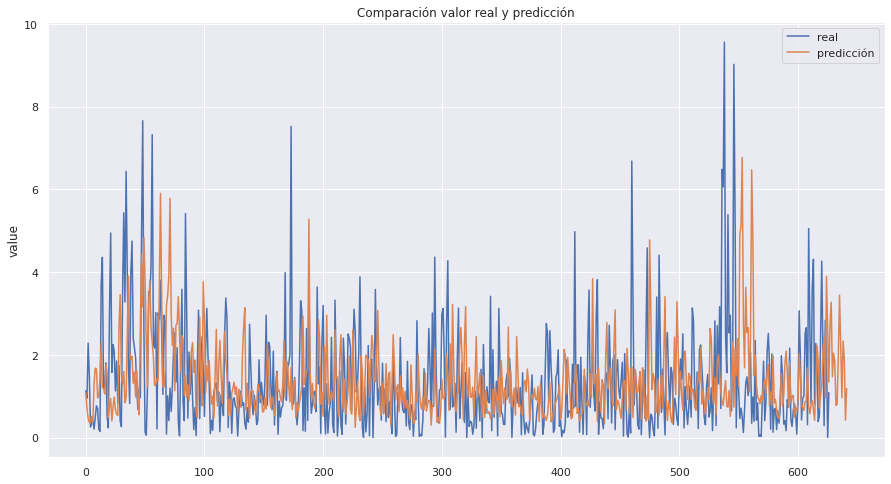

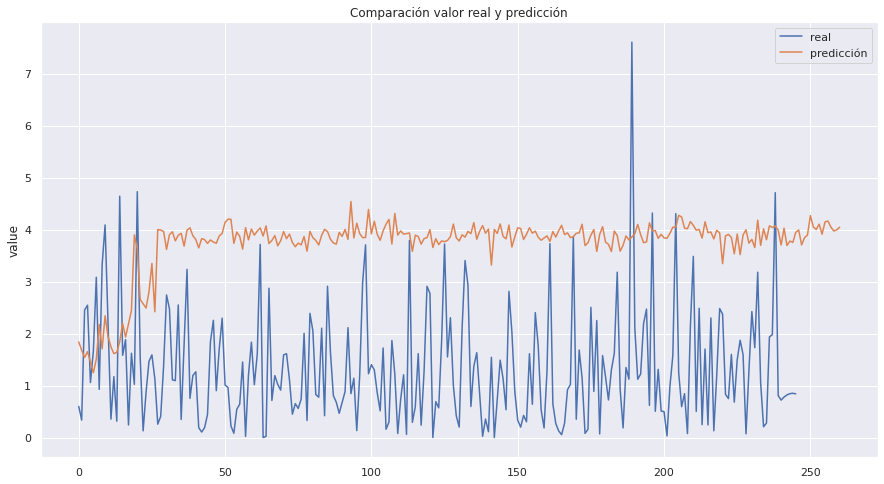

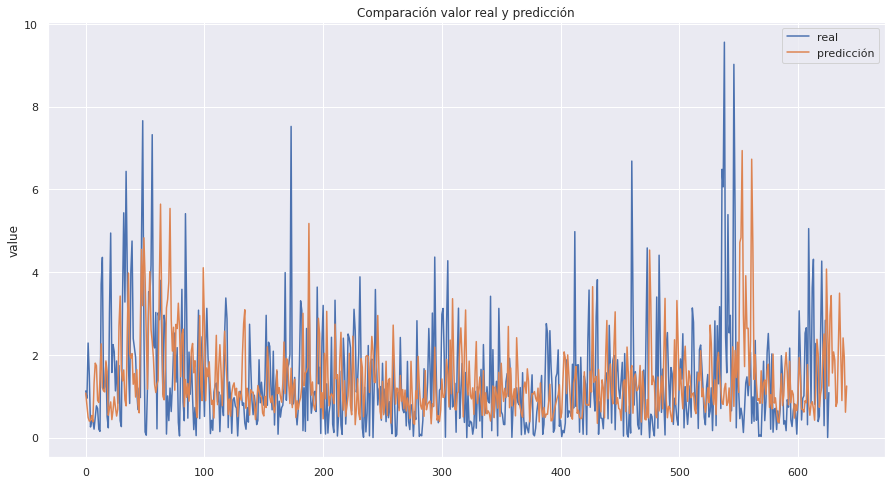

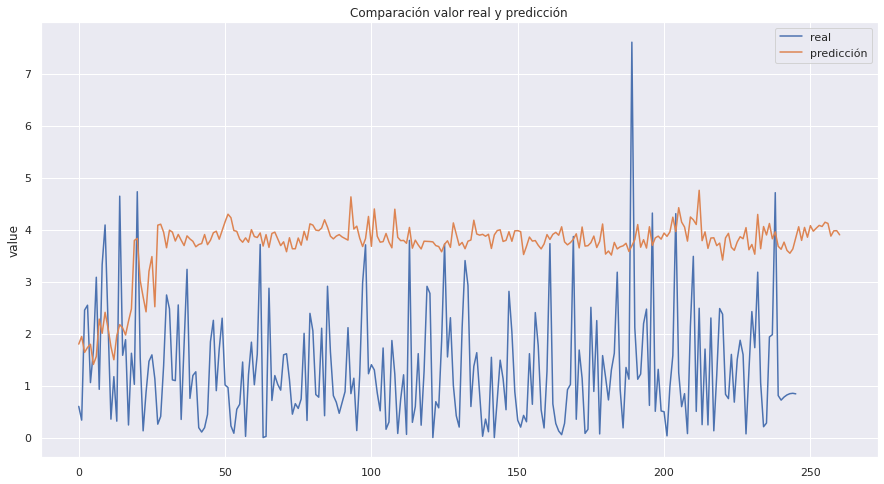

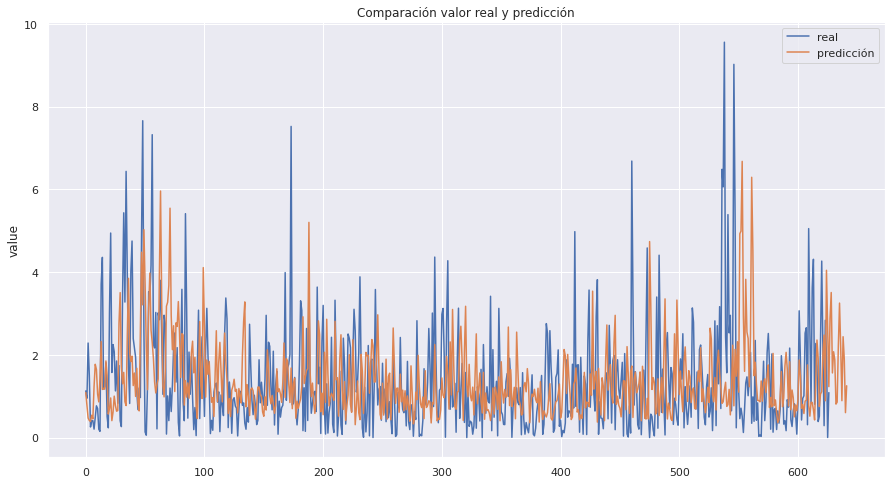

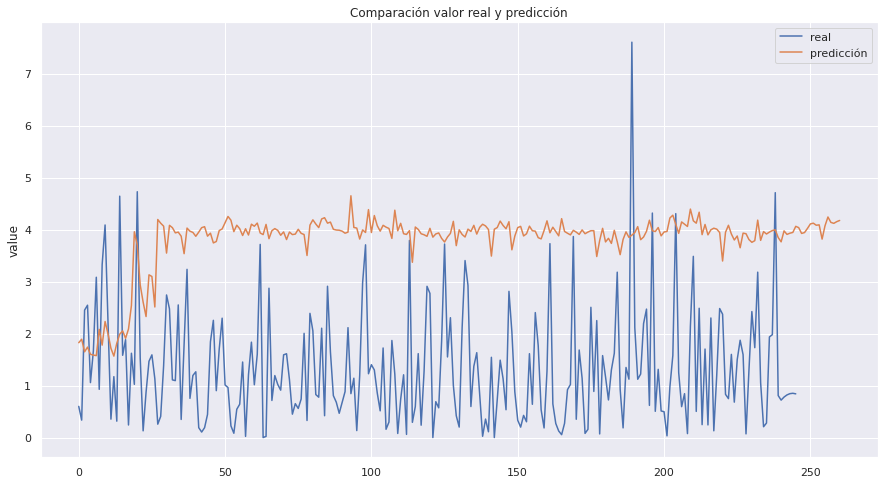

In [22]:
lags=[3,5,7,8,10,15]
n_estimators=[50,100,200,300,500]
results_models={i:{} for i in lags}
for lg in lags:
    for est in n_estimators:
        results_models[lg][est]=Model(df_data.copy(),df_label.copy(),lg,est)